<font size=4> Добрый день, Дмитрий! Меня зовут Алан, будем обмениваться с тобой опытом для успешного прохождения задания! Если не против, предлагаю общаться на ты (иначе дай знать, и перейдем на «вы»). Свои рекомендации буду оформлять в виде комментариев в Markdown ячейках:<br><strong>
    <li> <font color='red'> «❌ красный цвет» </font> – важно исправить или внести пояснения
    <li> <font color='orange'> «⚠️желтый цвет» </font>  – учесть, но можно не исправлять 
    <li> <font color='green'> «✔️ зеленый цвет» </font> – все отлично, плюс альтернативные пути решения задачи
    <li>   <font color='steelblue'>«синий цвет» </font> - просто текст комментария
     </strong>
<br> В скобках буду указывать версию комментария. Прошу при внесении правок мои комментарии не удалять, а свои писать в соседних ячейках и выделять удобным цветом. Так коммуникация будет проходить эффективнее 👍.<br>
</font>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Путь к файлу:
/datasets/autos.csv

Описание данных:

Признаки:

DateCrawled — дата скачивания анкеты из базы<br>
VehicleType — тип автомобильного кузова<br>
RegistrationYear — год регистрации автомобиля<br>
Gearbox — тип коробки передач<br>
Power — мощность (л. с.)<br>
Model — модель автомобиля<br>
Kilometer — пробег (км)<br>
RegistrationMonth — месяц регистрации автомобиля<br>
FuelType — тип топлива<br>
Brand — марка автомобиля<br>
NotRepaired — была машина в ремонте или нет<br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>
Целевой признак:<br>

Price — цена (евро)<br>

<div class='alert alert-success'> ✔️Хорошо, что есть описание, по прошествии времени оно поможет сориентироваться в работе и восстановить схему своих действий.



</div>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')

## Подготовка данных

### Чтение данных

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Наименования столбцов не по канону, меняем на правильные

In [5]:
df.columns = df.columns.map(lambda x: re.sub( '(?<!^)(?=[A-Z])', '_', x ).lower())

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Проверка на дубликаты

In [7]:
df.duplicated().sum()

4

In [8]:
df[df.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [9]:
df.shape

(354369, 16)

#### Удаление дубликатов

In [10]:
df = df.drop(df[df.duplicated() == True].index)

In [11]:
df.shape

(354365, 16)

In [12]:
df.duplicated().sum()

0

<div class='alert alert-success'> ✔️ Хорошо, явные дубликаты удалили. Обрати внимание, что практика удаления дубликатов до фильтрации неинформативных колонок (например, DateCrawled и LastSeen) оставляет неявные дубли. Хотел подчеркнуть, что, возможно, следует дубликаты определять после удаления таких колонок, чтобы и явные, и неявные найти сразу.
</div>

In [13]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [14]:
df[df.registration_year<1910]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,NaN,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,NaN,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323443,2016-03-26 20:58:27,30,NaN,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
325739,2016-03-30 11:36:35,400,NaN,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,8060,2016-04-01 06:16:46
340759,2016-04-04 23:55:47,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01


### Удаление неинформативных столбцов

Нижеперечисленные столбцы не несут важной информации для создаваемых моделей, а напротив, могут только усложнить их обучение. По этой причине они подлежат удалению.<br>
DateCrawled — дата скачивания анкеты из базы<br>
DateCreated — дата создания анкеты<br>
LastSeen — дата последней активности пользователя<br>
PostalCode

In [15]:
df = df.drop(['date_crawled','date_created','last_seen','postal_code'], axis=1)

<div class='alert alert-success'> ✔️Да, эти колонки нам не пригодятся
</div>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
 11  number_of_pictures  354365 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


### Проверка значений

In [17]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0


Столбец **number_of_pictures** содержит только нулевые значения, поэтому удалим его

In [18]:
df = df.drop(['number_of_pictures'], axis=1)

<div class='alert alert-success'> ✔️ Отличная заметка
</div>

**registration_year**

**registration_year** содержит аномальные значения (от 0 до 9999)

In [19]:
df.registration_year.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [20]:
sorted(df.registration_year.unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

Строки, со значениями ниже 1910 и выше 2019 удалим:

In [21]:
df.shape

(354365, 11)

Подсчет количества строк, с аномальными годами регистрации

In [22]:
abnormal_year = df[(df.registration_year<1910) | (df.registration_year>2019)].price.count()
abnormal_year

171

In [23]:
print(f'Процент строк с аномальными значениями года регистрации  {abnormal_year/df.shape[0]:.2%}')

Процент строк с аномальными значениями года регистрации  0.05%


Удаление значений

In [24]:
df = df.drop(df[df.registration_year <1910].index)

In [25]:
df = df.drop(df[df.registration_year >2019].index)

In [26]:
df.shape

(354194, 11)

<div class='alert alert-warning'>⚠️ Хорошо, явно неправильные значения из года регистраци удалили. А как считаешь по дате скачивания можно что-то сказать о верхней границе года регистрации?</div>




<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    Год регистрации не превышает года в дате размещения анкеты. Может даже совпасть, но не обязательно
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>


Точно, можешь фильтровать.
</div>

<div class='alert alert-danger'>❌(2)Давай заполнение пропусков переделаем. Price нельзя заполнять (нули фильтруй просто) и использовать значения при заполнении, так как можно создать искусственную зависимость между ценой и другими параметрами, что скажется на качестве итоговой оценки. Исходи их того, что target ты будешь знать только для части данных (тренировочных).<br>
Обработку можешь сделать проще - заполни заглушками или модами, еще лучше модами по категории  <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/zapolnenie-propuskov-kategorialnoi-modoi-6278da62f680416ea338bd9c'>как тут</a>. В целом, если идешь сложным путем, добавляй пояснения и понятные названия переменным, иначе читателю не ясно, что ты хочешь сделать.
    
    
</div>

### Заполнение пропусков

In [27]:
df.isna().sum()

price                     0
vehicle_type          37319
registration_year         0
gearbox               19695
power                     0
model                 19630
kilometer                 0
registration_month        0
fuel_type             32767
brand                     0
repaired              71007
dtype: int64

Переведем нулевые значения в Nan

In [28]:
df['power'] = df['power'].astype(float)

In [29]:
df.loc[df["power"] == 0 , "power"] = np.nan

Удаление строк с пропусками в 5 столбцах

In [30]:
df = df[~(df.vehicle_type.isna() & 
            df.gearbox.isna() & 
            df.power.isna() & 
            df.model.isna() &
            df.fuel_type.isna())]

#### repaired 

Будем предполагать, что неуказанные значения по ремонту означает, что ремонта не было

In [31]:
df['repaired'] = df['repaired'].fillna('no')

In [32]:
df.groupby('repaired')['repaired'].count()

repaired
no     316105
yes     36011
Name: repaired, dtype: int64

#### **Fuel_type**

Тип топлива заполним модой, исходя из известных **brand, vehicle_type','registration_year'**<br>
Остатки заполним модой, исходя из известных **brand, 'registration_year'**<br>

ПОлучаем таблицу с пропусками

In [33]:
df1 = df[df['fuel_type'].isna()]

In [34]:
df1

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
9,999,small,1998,manual,101.0,golf,150000,0,NaN,volkswagen,no
13,2500,wagon,2004,manual,131.0,passat,150000,2,NaN,volkswagen,no
26,5555,NaN,2017,manual,125.0,c4,125000,4,NaN,citroen,no
36,1600,other,1991,manual,75.0,kadett,70000,0,NaN,opel,no
41,7500,sedan,2002,auto,306.0,e_klasse,150000,4,NaN,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...,...
354329,350,small,1996,NaN,65.0,punto,150000,0,NaN,fiat,no
354339,3850,convertible,2006,manual,108.0,2_reihe,125000,2,NaN,peugeot,no
354346,2600,NaN,2005,auto,NaN,c_klasse,150000,9,NaN,mercedes_benz,no
354351,1900,NaN,2000,manual,110.0,NaN,150000,7,NaN,volkswagen,no


Группируем и считаем количество

In [35]:
df11 = df.groupby(['brand','vehicle_type','registration_year','fuel_type']).size().reset_index()

In [36]:
df11

,brand,vehicle_type,registration_year,fuel_type,0
0,alfa_romeo,convertible,1965,petrol,1
1,alfa_romeo,convertible,1972,petrol,2
2,alfa_romeo,convertible,1974,petrol,1
3,alfa_romeo,convertible,1977,petrol,3
4,alfa_romeo,convertible,1979,petrol,3
...,...,...,...,...,...
11042,volvo,wagon,2012,gasoline,14
11043,volvo,wagon,2012,petrol,1
11044,volvo,wagon,2013,gasoline,7
11045,volvo,wagon,2013,petrol,3


<div class='alert alert-danger'>❌(3)Здесь, как я писал, к price не надо обращаться. Считай, что для части датафрейма ты не знаешь эту колонку (валидационная и тестовая выборки). Для подсчета количества строк задавай size() после группировки, тогда не нужен будет столбец с агрегацией count.<br> Кроме того, чтобы "оставить группу с максимальным количеством записей" ниже keep last разве нужен?<br>
    
В целом логика заполнения хорошая, просто реализовано сложновато из-за того, что в функциях происходит внутренняя модификация датафрейма (внешняя зависимость), переменные с неговорящими названиями, работаешь на уровне ячеек, а не колонок и столбцов соответственно, код исполняется дольше. Я бы советовал переделать блок в стиле заполнения мощности, там у тебя все прекрасно получилось. Просто ты сам по прошествии времени не вспомнишь, что делал, если оставить так.

</div>

<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    В стиле power работает только с числовыми значениями. Transform в данном случае не сработал с mode, а может я неправильно делал<br>
    Хотел сделать заполнение модами не только по одной категории, а по группировке категорий, что более правильно на мой взгляд. Более дифференцированное заполнение 
</div>

<div class='alert alert-success'> <strong>Ревьюер(4)</strong> <br>

С модами тоже должно все работать <a href='https://teletype.in/@dt_analytic/uDTcdAjzrcg'>как здесь</a>

</div>

Сортируем по убыванию и оставляем группу с максимальным количеством записей и нужным видом топлива

In [37]:
df11= df11.sort_values(0,ascending = False).drop_duplicates(['brand','vehicle_type','registration_year'])


In [38]:
df11= df11.rename({0: 'count'}, axis='columns')

In [39]:
df11

,brand,vehicle_type,registration_year,fuel_type,count
10555,volkswagen,small,1999,petrol,1592
10427,volkswagen,sedan,1999,petrol,1470
10423,volkswagen,sedan,1998,petrol,1316
10544,volkswagen,small,1997,petrol,1215
10550,volkswagen,small,1998,petrol,1169
...,...,...,...,...,...
5656,mitsubishi,coupe,1988,petrol,1
5655,mitsubishi,coupe,1986,petrol,1
5654,mitsubishi,coupe,1983,petrol,1
5653,mitsubishi,coupe,1982,petrol,1


Функция для заполнения пропуска в столбце Fuel_type

In [40]:
def aaa(row):
    """
    Заполнение Fuel_type
    """
    df1.loc[((df1.brand == row[0]) & (df1.vehicle_type == row[1]) & (df1.registration_year == row[2]) ), 'fuel_type'] = row[3]

In [41]:
def aaa1(row):
    df1.loc[((df1.brand == row[0]) & (df1.registration_year == row[1]) ), 'fuel_type'] = row[2]

Применение функции заполнения столбца для каждой строки в таблице с пропусками

In [42]:
%%time
df11.apply(aaa,axis=1)

CPU times: user 28.2 s, sys: 49 ms, total: 28.3 s
Wall time: 28.3 s


10555    None
10427    None
10423    None
10544    None
10550    None
         ... 
5656     None
5655     None
5654     None
5653     None
5523     None
Length: 6661, dtype: object

In [43]:
df1.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
9,999,small,1998,manual,101.0,golf,150000,0,petrol,volkswagen,no
13,2500,wagon,2004,manual,131.0,passat,150000,2,gasoline,volkswagen,no
26,5555,NaN,2017,manual,125.0,c4,125000,4,NaN,citroen,no
36,1600,other,1991,manual,75.0,kadett,70000,0,petrol,opel,no
41,7500,sedan,2002,auto,306.0,e_klasse,150000,4,petrol,mercedes_benz,no


In [44]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


Обновляем исходный датафрейм полученными значениями

In [45]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

In [46]:
df1 = df[df['fuel_type'].isna()]

In [47]:
df12 = df.groupby(['brand','registration_year','fuel_type']).size().reset_index()

In [48]:
df12= df12.sort_values(0,ascending = False).drop_duplicates(['brand','registration_year'])

In [49]:
df12= df12.rename({0: 'count'}, axis='columns')

In [50]:
df12

,brand,registration_year,fuel_type,count
3632,volkswagen,1999.0,petrol,4230
3626,volkswagen,1998.0,petrol,3577
3620,volkswagen,1997.0,petrol,3054
3637,volkswagen,2000.0,petrol,3022
2310,opel,1999.0,petrol,3021
...,...,...,...,...
948,ford,1928.0,petrol,1
947,ford,1927.0,petrol,1
946,ford,1919.0,petrol,1
944,fiat,2019.0,petrol,1


In [51]:
%%time
df12.apply(aaa1,axis=1)

CPU times: user 3.19 s, sys: 8.1 ms, total: 3.2 s
Wall time: 3.2 s


3632    None
3626    None
3620    None
3637    None
2310    None
        ... 
948     None
947     None
946     None
944     None
0       None
Length: 1875, dtype: object

In [52]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

In [53]:
df.isna().sum()

price                     0
vehicle_type          35241
registration_year         0
gearbox               17617
power                 38020
model                 17552
kilometer                 0
registration_month        0
fuel_type                69
brand                     0
repaired                  0
dtype: int64

In [54]:
def plot_column(column,title,df=df):
    """
    Построение графика boxplot для заданного столбца
    """
    sns.boxplot(data=df[column]);
    p25 = df[column].quantile(.25)
    p75 = df[column].quantile(.75)
    iqr = p75 - p25
    plt.ylim(0,p75 + 1.75*iqr);
    #plt.ylabel('Мощность (л.с.)');
    plt.title(title);

In [55]:
def abnormal_column(column,df=df,price='price'):
    """
    Подсчет количества выбросов и квантилей 5%, 95%
    """
    p05 = df[column].quantile(.05)
    p95 = df[column].quantile(.95)
    abnormal_value = df[(df[column]<p05) | (df[column]>p95)][price].count()
    return abnormal_value,p05,p95

#### **Восстановление vehicle_type**

Заполняем наиболее часто встречающимися значениями, рассчитанными на основе группировки по **brand, model,registration_year**

In [56]:
df1 = df[df['vehicle_type'].isna()]

In [57]:
df1 

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480.0,NaN,1993.0,manual,NaN,golf,150000.0,0.0,petrol,volkswagen,no
16,300.0,NaN,2016.0,NaN,60.0,polo,150000.0,0.0,petrol,volkswagen,no
22,2900.0,NaN,2018.0,manual,90.0,meriva,150000.0,5.0,petrol,opel,no
26,5555.0,NaN,2017.0,manual,125.0,c4,125000.0,4.0,petrol,citroen,no
31,899.0,NaN,2016.0,manual,60.0,clio,150000.0,6.0,petrol,renault,no
...,...,...,...,...,...,...,...,...,...,...,...
354338,180.0,NaN,1995.0,NaN,NaN,NaN,125000.0,3.0,petrol,opel,no
354346,2600.0,NaN,2005.0,auto,NaN,c_klasse,150000.0,9.0,gasoline,mercedes_benz,no
354351,1900.0,NaN,2000.0,manual,110.0,NaN,150000.0,7.0,petrol,volkswagen,no
354361,5250.0,NaN,2016.0,auto,150.0,159,150000.0,12.0,petrol,alfa_romeo,no


In [58]:
df_vt = df.groupby(['brand','model','registration_year','vehicle_type']).size().reset_index()

In [59]:
df_vt = df_vt.sort_values(0,ascending = False).drop_duplicates(['brand','model','registration_year'])

In [60]:
df_vt= df_vt.rename({0: 'count'}, axis='columns')

In [61]:
df_vt

,brand,model,registration_year,vehicle_type,count
12225,volkswagen,golf,1999.0,sedan,1223
12218,volkswagen,golf,1998.0,sedan,1181
8040,opel,corsa,1997.0,small,939
8052,opel,corsa,1999.0,small,924
8062,opel,corsa,2001.0,small,916
...,...,...,...,...,...
6840,mini,clubman,2015.0,wagon,1
6839,mini,clubman,2014.0,wagon,1
6816,mini,clubman,2002.0,coupe,1
6815,mercedes_benz,vito,2014.0,bus,1


In [62]:
def fill_vt(row):
    df1.loc[((df1.brand == row[0]) & (df1.model == row[1]) & (df1.registration_year == row[2]) ), 'vehicle_type'] = row[3]

In [63]:
def fill_vt1(row):
    df1.loc[((df1.brand == row[0]) & (df1.registration_year == row[1]) ), 'vehicle_type'] = row[2]

In [64]:
%%time
df_vt.apply(fill_vt,axis=1)

CPU times: user 29.4 s, sys: 48 ms, total: 29.4 s
Wall time: 29.4 s


12225    None
12218    None
8040     None
8052     None
8062     None
         ... 
6840     None
6839     None
6816     None
6815     None
6763     None
Length: 5924, dtype: object

In [65]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

Восстановление по brand и registration_year

In [66]:
df1 = df[df['vehicle_type'].isna()]

In [67]:
df_vt = df.groupby(['brand','registration_year','vehicle_type']).size().reset_index()

In [68]:
df_vt = df_vt.sort_values(0,ascending = False).drop_duplicates(['brand','registration_year'])

In [69]:
df_vt= df_vt.rename({0: 'count'}, axis='columns')

In [70]:
df_vt.apply(fill_vt1,axis=1)

6575    None
6567    None
6584    None
567     None
574     None
        ... 
3873    None
3876    None
3877    None
3880    None
3885    None
Length: 1804, dtype: object

In [71]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

In [72]:
df.isna().sum()

price                     0
vehicle_type           6021
registration_year         0
gearbox               17617
power                 38020
model                 17552
kilometer                 0
registration_month        0
fuel_type                69
brand                     0
repaired                  0
dtype: int64

In [73]:
dff = df.query('vehicle_type.isna() and gearbox.isna() and power.isna() and model.isna() and fuel_type.isna()')

In [74]:
dff

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired


#### model

Заполняем наиболее часто встречающимися значениями, рассчитанными на основе группировки по brand, registration_year

In [75]:
df1 = df[df['model'].isna()]

In [76]:
df1

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes
59,1.0,suv,1994.0,manual,286.0,NaN,150000.0,11.0,gasoline,sonstige_autos,no
81,350.0,small,1997.0,manual,54.0,NaN,150000.0,3.0,petrol,fiat,yes
115,0.0,small,1999.0,NaN,NaN,NaN,5000.0,0.0,petrol,volkswagen,no
135,1450.0,sedan,1992.0,manual,136.0,NaN,150000.0,0.0,petrol,audi,no
...,...,...,...,...,...,...,...,...,...,...,...
354234,5000.0,sedan,2002.0,auto,170.0,NaN,150000.0,0.0,petrol,audi,no
354245,560.0,small,2001.0,auto,170.0,NaN,90000.0,0.0,petrol,fiat,yes
354321,9400.0,wagon,2007.0,manual,200.0,NaN,150000.0,4.0,gasoline,sonstige_autos,yes
354338,180.0,small,1995.0,NaN,NaN,NaN,125000.0,3.0,petrol,opel,no


In [77]:
df_mod = df.groupby(['brand','registration_year','model']).size().reset_index()

In [78]:
df_mod = df_mod.sort_values(0,ascending = False).drop_duplicates(['brand','registration_year'])

In [79]:
df_mod= df_mod.rename({0: 'count'}, axis='columns')

In [80]:
def fill_mod(row):
    df1.loc[((df1.brand == row[0]) & (df1.registration_year == row[1])), 'model'] = row[2]

In [81]:
%%time
df_mod.apply(fill_mod,axis=1)

CPU times: user 3.05 s, sys: 8.02 ms, total: 3.06 s
Wall time: 3.06 s


6241    None
6230    None
6254    None
6195    None
625     None
        ... 
2904    None
2905    None
2906    None
2907    None
0       None
Length: 1817, dtype: object

In [82]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

In [83]:
df.isna().sum()

price                     0
vehicle_type           6021
registration_year         0
gearbox               17617
power                 38020
model                  2669
kilometer                 0
registration_month        0
fuel_type                69
brand                     0
repaired                  0
dtype: int64

#### gearbox

Заполняем наиболее часто встречающимися значениями, рассчитанными на основе группировки по **'brand','registration_year','model'**

In [84]:
df1 = df[df['gearbox'].isna()]

In [85]:
df_gea = df.groupby(['brand','registration_year','model','gearbox']).size().reset_index()

In [86]:
df_gea = df_gea.sort_values(0,ascending = False).drop_duplicates(['brand','registration_year','model'])

In [87]:
df_gea= df_gea.rename({0: 'count'}, axis='columns')

In [88]:
df_gea

,brand,registration_year,model,gearbox,count
9077,volkswagen,1999.0,golf,manual,2081
9058,volkswagen,1998.0,golf,manual,1964
9098,volkswagen,2000.0,golf,manual,1727
9037,volkswagen,1997.0,golf,manual,1516
9003,volkswagen,1995.0,golf,manual,1388
...,...,...,...,...,...
8185,subaru,2018.0,other,manual,1
4101,mazda,1985.0,rx_reihe,manual,1
8182,subaru,2018.0,forester,manual,1
8183,subaru,2018.0,legacy,auto,1


In [89]:
def fill_gea(row):
    df1.loc[((df1.brand == row[0]) & (df1.registration_year == row[1]) & (df1.model == row[2])), 'gearbox'] = row[3]

In [90]:
%%time
df_gea.apply(fill_gea,axis=1)

CPU times: user 19.6 s, sys: 19.9 ms, total: 19.6 s
Wall time: 19.6 s


9077    None
9058    None
9098    None
9037    None
9003    None
        ... 
8185    None
4101    None
8182    None
8183    None
0       None
Length: 6536, dtype: object

In [91]:
df.update(df1, join='left', overwrite=True, filter_func=None, errors='ignore')

In [92]:
df.isna().sum()

price                     0
vehicle_type           6021
registration_year         0
gearbox                 638
power                 38020
model                  2669
kilometer                 0
registration_month        0
fuel_type                69
brand                     0
repaired                  0
dtype: int64

#### **Power** 

Восстановление power по **'brand','model','fuel_type','registration_year'**

In [93]:
df['avg_power'] = df.groupby(['brand','model','fuel_type','registration_year'])['power'].transform('mean')

In [94]:
df.loc[df['power'].isna(),'power'] = df['avg_power']

In [95]:
df = df.drop('avg_power',axis=1)

Восстановление power по 'brand','model','fuel_type'

In [96]:
df['avg_power'] = df.groupby(['brand','model','fuel_type'])['power'].transform('mean')

In [97]:
df.loc[df['power'].isna(),'power'] = df['avg_power']

In [98]:
df = df.drop('avg_power',axis=1)

Восстановление power по 'brand','model','fuel_type'

In [99]:
df['avg_power'] = df.groupby(['brand','model','registration_year'])['power'].transform('mean')

In [100]:
df.loc[df['power'].isna(),'power'] = df['avg_power']

In [101]:
df = df.drop('avg_power',axis=1)

In [102]:
df.isna().sum()

price                    0
vehicle_type          6021
registration_year        0
gearbox                638
power                  731
model                 2669
kilometer                0
registration_month       0
fuel_type               69
brand                    0
repaired                 0
dtype: int64

In [103]:
ddf = df.copy()

In [104]:
df.shape[0]

352116

In [105]:
df = df.dropna()

In [106]:
df.shape[0]

343284

<div class='alert alert-warning'>⚠️Хорошо, что знаешь математические способы фильтрации выбросов. Но рекомендовал бы тебе дополнительно смотреть на значения для определения пределов. Например, у нас остались нулневые значения мощности и мы ограничили датасет недорогими авто. 

</div>

**registration_year**

In [107]:
a = df['registration_year'].value_counts();

In [108]:
df1 = df['registration_year'].value_counts().rename_axis('year').reset_index(name='coun')

In [109]:
df1

,year,coun
0,2000.0,23560
1,1999.0,22639
2,2005.0,21714
3,2001.0,20036
4,2006.0,19770
...,...,...
83,1947.0,1
84,1933.0,1
85,1919.0,1
86,1931.0,1


In [110]:
df1.shape

(88, 2)

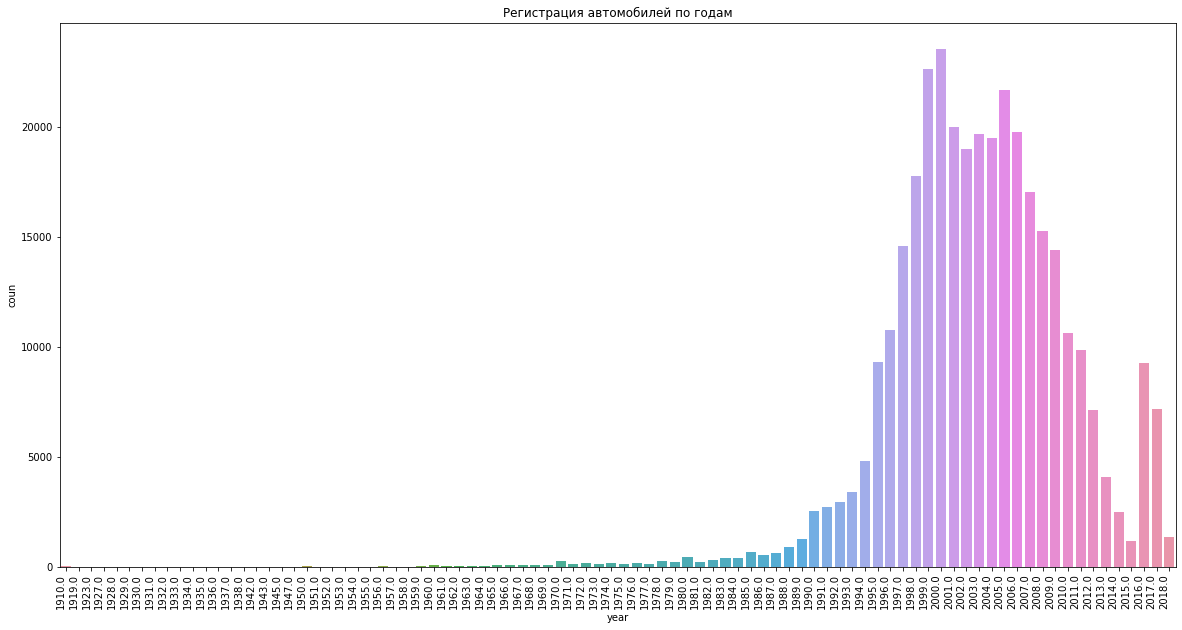

In [111]:
fig, ax = plt.subplots(figsize=(20, 10));
sns.barplot(data=df1,x='year',y='coun');
plt.xticks(rotation=90, ha='right');
plt.title('Регистрация автомобилей по годам')
plt.show()

Из графика видно, что удалив, данные старше 1980 года, получим распределение, близкое к нормальному по признаку "количество автомобилей, зарегистрированных в году"

In [112]:
df1 = df1.drop(df1[df1.year<1980].index)

In [113]:
df1.shape

(39, 2)

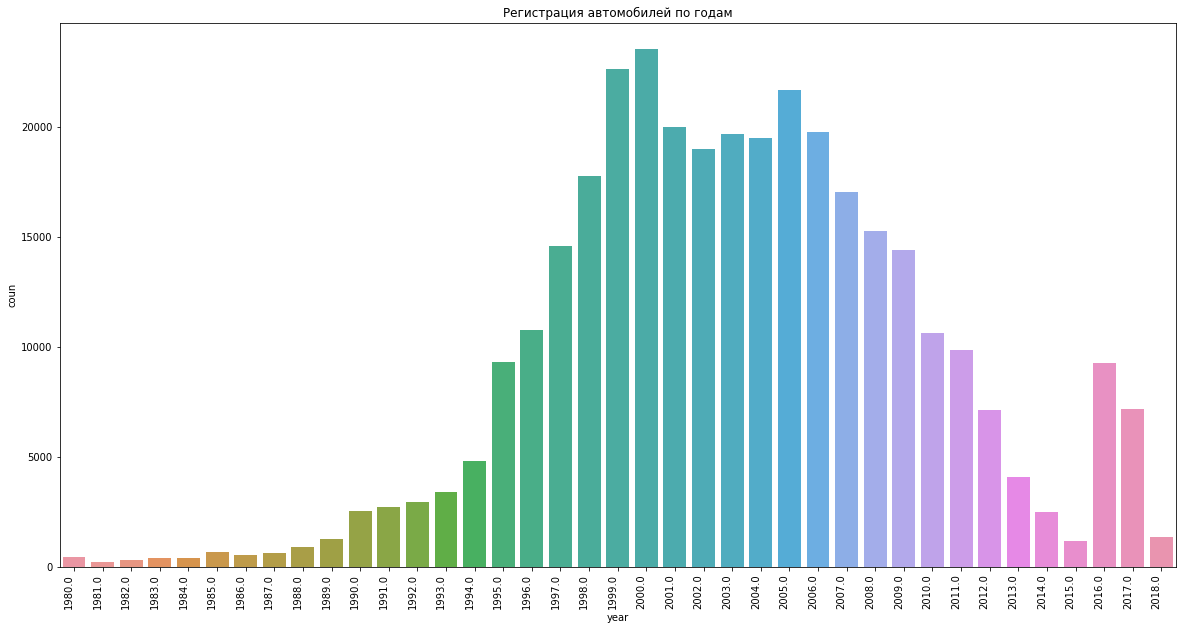

In [114]:
fig, ax = plt.subplots(figsize=(20, 10));
sns.barplot(data=df1,x='year',y='coun');
plt.xticks(rotation=90, ha='right');
plt.title('Регистрация автомобилей по годам')
plt.show()

Удалим эти сведения из исходного датафрейма

In [115]:
df = df.drop(df[df.registration_year<1980].index)

**registration_month**

Большая часть автомобилей старше 5 лет. По этой причине рассматривать **месяц регистрации** автомобиля в качестве информативного не иммет смысла. Уберем этот столбец из датафрейма

In [116]:
df = df.drop(['registration_month'], axis=1)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340740 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              340740 non-null  float64
 1   vehicle_type       340740 non-null  object 
 2   registration_year  340740 non-null  float64
 3   gearbox            340740 non-null  object 
 4   power              340740 non-null  float64
 5   model              340740 non-null  object 
 6   kilometer          340740 non-null  float64
 7   fuel_type          340740 non-null  object 
 8   brand              340740 non-null  object 
 9   repaired           340740 non-null  object 
dtypes: float64(4), object(6)
memory usage: 28.6+ MB


In [118]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480.0,sedan,1993.0,manual,104.439623,golf,150000.0,petrol,volkswagen,no
1,18300.0,coupe,2011.0,manual,190.000000,a4,125000.0,gasoline,audi,yes
2,9800.0,suv,2004.0,auto,163.000000,grand,125000.0,gasoline,jeep,no
3,1500.0,small,2001.0,manual,75.000000,golf,150000.0,petrol,volkswagen,no
4,3600.0,small,2008.0,manual,69.000000,fabia,90000.0,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150.0,bus,2000.0,manual,115.305556,zafira,150000.0,petrol,opel,no
354364,0.0,small,2005.0,manual,95.317073,colt,150000.0,petrol,mitsubishi,yes
354366,1199.0,convertible,2000.0,auto,101.000000,fortwo,125000.0,petrol,smart,no
354367,9200.0,bus,1996.0,manual,102.000000,transporter,150000.0,gasoline,volkswagen,no


In [119]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [120]:
df['power'] = df['power'].astype(int)

<div class='alert alert-danger'>❌Так мы теряем контроль над работой с пропусками. Сейчас за тебя это делает get_dummies, если специально так сделал, то надо пояснить, как она заполняет. Либо давай заполним их сами, новым значением или модами по категории, например, бренду, <a href = 'https://zen.yandex.ru/media/id/5ee6f73b7cadb75a66e4c7e3/zapolnenie-propuskov-kategorialnoi-modoi-6278da62f680416ea338bd9c'> как здесь </a>. 

</div>

<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    Пропуски в признаках были заполнены
</div>

### Преобразование датафрейма

#### OHE

Категориальные признаки с помощью техники прямого кодирования (One-Hot Encoding, OHE) будут преобразованы в числовые. Для прямого кодирования в библиотеке pandas есть функция pd.get_dummies(). Аргумент drop_first=True - для избежания ловушки

In [121]:
ddf = df.copy()

In [122]:
df=df[~(df.price == 0)]

In [123]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
0,480.0,1993.0,104,150000.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300.0,2011.0,190,125000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800.0,2004.0,163,125000.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500.0,2001.0,75,150000.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600.0,2008.0,69,90000.0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200.0,2004.0,225,150000.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
354363,1150.0,2000.0,115,150000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354366,1199.0,2000.0,101,125000.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354367,9200.0,1996.0,102,150000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<div class='alert alert-warning'>⚠️
Хорошо, что в get_dummies используешь параметр  drop_first=True, который позволяет избавиться от фиктивных признаков. Однако на будущее отмечу, что в общем случае кодирование правильно настраивать (обучать) на тренировочной выборке (о других предполагаем, что модель ничего не знает), <a href='https://teletype.in/@dt_analytic/yP6vP3B3D6h'> как здесь </a>.

</div>

#### Разделение на выборки

df_train - обучающая выборка<br>
df_test - тестовая выборка<br>
df_t - тестовая

In [124]:
df_train, df_test = train_test_split(df_ohe, test_size=0.4, random_state=12345)

In [125]:
df_test,df_t = train_test_split(df_test, test_size=0.5, random_state=12345)

In [126]:
df_train.shape[0]

198819

In [127]:
df_test.shape[0]

66273

In [128]:
df_t.shape[0]

66273

<div class='alert alert-danger'>❌ Хорошо, создал две выборки: обучающую и валидационную. Валидационная нужна для отбора модели, на train выборке это делать неправильно, так как некоторые модели могут просто запомнить все решения и показать идеальный результат. А тест выборка используется для финального тестирования лучшей модели, ее больше ни для чего использовать нельзя (получается у нас ее пока нет). Поэтому: 
<li> Либо сделай три выборки - одну для обучения, другую для сравнения моделей между собой и третью для теста лучшей модели (просто добавь еще train_test_split). Время обучения тогда следует измерять по train выборке, а предсказания - по valid (либо по блокам с %%time, либо с модулем time, примеры <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/taimmenedjment-s-python-60bb502abbd5974178951ac9'> здесь </a> ). 
<li> Либо во всех алгоритмах проводи внутреннюю кросс-валидацию на train выборке с GridSearchCV/RandomizedSearchCV (валидационная ошибка будет в атрибуте best_score_) или cross_val_score/cross_validate. Вторую выборку не используй вплоть до финального тестирования лучшей модели. Время тогда следует измерять и для обучения и предсказания по train выборке или с GridSearchCV/RandomizedSearchCV через <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/kliuchevye-pliushki-ot-podbora-giperparametrov-v-sklearn-63464daff5b09e156159e05a'>атрибут cv_results_ </a>, cross_validate непосредственно возвращает требуемые временные метрики.
    

</div> 

<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    df_train - обучающая<br>
    df_test - валидационная<br>
    df_t - тестовая<br>
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

ОК


</div>

Выделение признаков и целевого признака<br>
features - признаки<br>
target - цель

In [129]:
train_features = df_train.drop(['price'], axis=1)
train_target = df_train['price']
test_features = df_test.drop(['price'], axis=1)
test_target = df_test['price']
t_features = df_t.drop(['price'], axis=1)
t_target = df_t['price']

#### Масштабирование

Для приведения значения столбцов к единому измеряемому пространству, используем масштадирование с помощью модуля **StandardScaler**

In [130]:
numeric = train_features.iloc[:, :3].columns
scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])
t_features[numeric] = scaler.transform(t_features[numeric])

<div class='alert alert-success'> ✔️Отлично, признаки шкалировали, не забыли, что fit нужно делать только на train выборке.
</div>

### Вывод

* Были обнаружены и изменены неканоничные назнвания столбцов<br>
* Типы данных корректны<br>
* Неинформативные признаки, мещающие модели обучаться были удалены.<br>
* Дубликаты удалены<br>
* Аномальные значения, обнаруженные с столбцах были удалены. 
* Пропуски, имеющиеся в категориальных признаках бли максимально восстановлены<br>
* Категориальные признаки переведены в числовые.<br>
* Признаки отмасштабированы
* Созданы обучающая и тестовая выборки

## Обучение моделей

По заданию требуется обучать модели и в качестве метрики использовать RMSE. В нашей работе будет использоваться кросс-валидация, в которыю будем подставлять **score**, рассчитывающую метрику RMSE<br>
Значение метрики RMSE должно быть меньше 2500.

In [131]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

score = make_scorer(RMSE, greater_is_better=False)

### Линейная регресиия (LinearRegression)

In [132]:
model_lin_reg = LinearRegression()

In [133]:
%%time
model_lin_reg.fit(train_features, train_target)

CPU times: user 12.3 s, sys: 4.82 s, total: 17.1 s
Wall time: 17.6 s


LinearRegression()

In [134]:
%%time
predict_test = model_lin_reg.predict(test_features)

CPU times: user 83.7 ms, sys: 56.2 ms, total: 140 ms
Wall time: 119 ms


Подсчет метрики

In [135]:
print('RMSE на тестовой выборке: ', RMSE(test_target, predict_test).round(2))

RMSE на тестовой выборке:  2839.45


Значение метрики RMSE подходит нормоконтроль

<div class='alert alert-success'> ✔️Засекаешь время корректно и на fit, и на predict, только следим, чтобы одна выборка осталась не тронутой.
</div>


### Модель градиентного бустинга LGBMRegressor

In [136]:
model_lgbm = LGBMRegressor(random_state=12345)

In [137]:
parameters_grid = {'max_depth': [2, 4, 6],
                   'learning_rate': [0.03, 0.1],
                   'n_estimators': [50, 100, 200]}

In [138]:
grid_cv = GridSearchCV(model_lgbm, parameters_grid, scoring=score)

In [139]:
%%time
grid_cv.fit(train_features, train_target, verbose=True)

CPU times: user 9min 19s, sys: 25.8 s, total: 9min 45s
Wall time: 9min 48s


GridSearchCV(estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.03, 0.1], 'max_depth': [2, 4, 6],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(RMSE, greater_is_better=False))

<div class='alert alert-success'> ✔️Отлично, что умеешь подбирать гиперпараметры с GridSearchCV </div>

In [140]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-1712.6449262448216
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


**Обучение модели на лучших гиперпараметрах**

In [141]:
model_lgbm = LGBMRegressor(max_depth=6, n_estimators=200, learning_rate=0.1, random_state=12345)

In [142]:
%%time
model_lgbm.fit(train_features, train_target)

CPU times: user 8.26 s, sys: 237 ms, total: 8.49 s
Wall time: 8.48 s


LGBMRegressor(max_depth=6, n_estimators=200, random_state=12345)

In [143]:
%%time
pred_test = model_lgbm.predict(test_features)

CPU times: user 917 ms, sys: 94.4 ms, total: 1.01 s
Wall time: 1.08 s


In [144]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  1691.81


Значение метрики RMSE подходит нормоконтроль и оно почти в 2 раза лучше, чем на LinearRegression

### Модель стохастического градиентного спуска SGDRegressor

In [145]:
model_sgd = SGDRegressor(random_state=12345)

In [146]:
parameters_grid = {'alpha' : [0.0001, 0.001],
                   'max_iter': [1e3, 1e4],}

In [147]:
grid_cv = GridSearchCV(model_sgd, parameters_grid, scoring=score)

Поиск лучших гиперпараметров

In [148]:
%%time
grid_cv.fit(train_features, train_target)

CPU times: user 2min 57s, sys: 7.83 s, total: 3min 5s
Wall time: 3min 6s


GridSearchCV(estimator=SGDRegressor(random_state=12345),
             param_grid={'alpha': [0.0001, 0.001],
                         'max_iter': [1000.0, 10000.0]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [149]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-2869.5291633171782
{'alpha': 0.0001, 'max_iter': 1000.0}


In [150]:
model_sgd = SGDRegressor(alpha=0.0001, max_iter=1000.0,random_state=12345)

In [151]:
%%time
model_sgd.fit(train_features, train_target)

CPU times: user 14.2 s, sys: 309 ms, total: 14.5 s
Wall time: 14.5 s


SGDRegressor(max_iter=1000.0, random_state=12345)

<div class='alert alert-danger'>❌Давай здесь выведем время обучения тоже

</div>

<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    Выполнено
</div>

<div class='alert alert-success'> <strong>Ревьюер(2)</strong> <br>

Молодец


</div>

In [152]:
%%time
pred_test = model_sgd.predict(test_features)

CPU times: user 76.2 ms, sys: 41 ms, total: 117 ms
Wall time: 86.9 ms


In [153]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  2889.05


Значение метрики RMSE не проходит нормоконтроль. Значение метрики пока хуже всех.

### Модель градиентного бустинга XGBRegressor

In [154]:
model_xgb = XGBRegressor(verbosity=0, random_state=12345, n_job=-1)

In [155]:
parameters_grid = {'max_depth': [2, 4],
                   'n_estimators': [50, 100]}

In [156]:
grid_cv = GridSearchCV(model_xgb, parameters_grid, scoring=score)

In [157]:
%%time
grid_cv.fit(train_features, train_target, verbose=True)

CPU times: user 44min 49s, sys: 13.2 s, total: 45min 2s
Wall time: 45min 8s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_job=-1, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=12345, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
               

In [158]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-1760.4637839408156
{'max_depth': 4, 'n_estimators': 100}


In [159]:
model_xgb = XGBRegressor(verbosity=0, max_depth=4, n_estimators=100, random_state=12345, n_job=-1)

In [160]:
%%time
model_xgb.fit(train_features, train_target)

CPU times: user 4min 16s, sys: 1.03 s, total: 4min 17s
Wall time: 4min 18s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_job=-1, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [161]:
%%time
pred_test = model_xgb.predict(test_features)

CPU times: user 970 ms, sys: 50.7 ms, total: 1.02 s
Wall time: 1.02 s


In [162]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  1754.61


<div class='alert alert-success'> ✔️Молодец, что рассмотрел 4 модели
</div>


### Вывод

Модели имеют разную скорость подбора гиперпараметров, обучения и предсказания.
Градиентный бустинг имеет лучшие показания по сравнению с линейной регрессией и стохастическим градиентным спуском.

## Анализ моделей

Модели показали следующие результаты:

1. **Линейная регрессия LinearRegression:**<br>
RMSE - 2075.54, подбор гиперпараметров - 0 s, скорость обучения - 16 s, скорость предсказания - 127 ms<br>
2. **Модель стохастического градиентного спуска SGDRegressor**<br>
RMSE - 2081.43, подбор гиперпараметров - 9min 2s, скорость обучения - 20.2 s, скорость предсказания - 117 ms 3.<br> 
3. **Модель градиентного бустинга XGBRegressor**<br>
RMSE - 1316.07, подбор гиперпараметров - 1h 44min 30s, скорость обучения - 5min 22s, скорость предсказания - 1.13 s
4. **Модель градиентного бустинга LGBMRegressor**<br>
RMSE - 1367.18, подбор гиперпараметров - 12min 35s, скорость обучения - 12 s, скорость предсказания - 1.41 s

Наилучшая скорость у линейных моделей LinearRegression и SGDRegressor. Однако, качество предсказания противоположно - Очень низкое
Лучший результат в качестве предсказания у XGBoost и LightGBM. В тоже время XGBoost очень долгая модель по скорости обучения

<div class='alert alert-success'> ✔️ Хорошо, что выводы сформулированы в отдельном разделе. Рекомендовал бы оформлять результаты в более наглядном виде, например, <a href='https://dzen.ru/media/id/5ee6f73b7cadb75a66e4c7e3/otlichnyi-sposob-vizualizacii-prostyh-struktur-python-635f58ad857d443d738425a9'> в форме датафрейма</a>, чтобы произвести дополнительное впечатление на читателя.

</div>

### Вывод:

1. Наилучшая скорость у линейных моделей **LinearRegression** и **SGDRegressor**<br>
Качество предсказания - **Очень низкое**<br>
2. Лучший результат в качестве предсказания у **XGBoost и LightGBM**.<br>
**XGBoost** очень долгая модель по скорости обучения

<div class='alert alert-danger'>❌ Давай здесь проведем финальное тестирование лучшей модели на еще не использованной выборке (писал выше).
    
</div>

<div class='alert alert-danger'>❌ (2)Тестирование давай делать только для одной модели. Тест нужен для объективной оценки качества лучшей. Если сравнивать, то уже валидация получается, и возникает соблазн выбрать лучшую по тесту, что не объективно.
    
</div>

<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    Финальное тестирование
</div>


#### Тестовая выборка лучшей модели

**Линейная регресиия (LinearRegression)**

**Модель градиентного бустинга LGBMRegressor**

In [163]:
%%time
pred_t = model_lgbm.predict(t_features)

CPU times: user 1.01 s, sys: 81.5 ms, total: 1.09 s
Wall time: 1.08 s


In [164]:
print('RMSE на тестовой выборке: ', RMSE(t_target, pred_t).round(2))

RMSE на тестовой выборке:  1706.22


<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    На тестовой выборке результат оказался немного лучше, чем на валидационной
</div>


Для сравнения рассмотрим еще раз результаты все трех выборок:

**Тренировочная:**

In [165]:
%%time
pred_train = model_lgbm.predict(train_features)

CPU times: user 3.04 s, sys: 243 ms, total: 3.28 s
Wall time: 3.3 s


In [166]:
print('RMSE на тестовой выборке: ', RMSE(train_target, pred_train).round(2))

RMSE на тестовой выборке:  1675.44


<div class='alert alert-warning'>⚠️(4) В принте потом замени название выборки, а то везде тестовая стоит.

</div>

**Валидационная**

In [167]:
%%time
pred_valid = model_lgbm.predict(test_features)

CPU times: user 979 ms, sys: 87.9 ms, total: 1.07 s
Wall time: 1.06 s


In [168]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_valid).round(2))

RMSE на тестовой выборке:  1691.81


**Тестовая**

In [169]:
%%time
pred_t = model_lgbm.predict(t_features)

CPU times: user 968 ms, sys: 81.2 ms, total: 1.05 s
Wall time: 1.07 s


In [170]:
print('RMSE на тестовой выборке: ', RMSE(t_target, pred_t).round(2))

RMSE на тестовой выборке:  1706.22


<div class="alert alert-block alert-info"><b>Комментарий студента</b><br>
    Модель является устойчивой. Недообучения или переобучения не наблюдается. 
</div>

<div class="alert alert-block alert-info"><b>ВОПРОС</b><br>
    А какой минимальный RMSE был достигнут кем-либо в этой работе?
</div>


<div class='alert alert-success'> <strong>Ревьюер(3)</strong> <br>

Тут сложно сказать, я не вел подсчет. RMSE сильно зависит от фильтрации датасета (некоторые срезают больше дорогие авто, некоторые меньше, тут rmse и начинает бегать) В принципе у тебя в области оптимальных значений. 


</div>

### Итоговый вывод

Данные загружены и обработаны, удалены дубликаты и аномальные значения. ИСключены из датафрейма категориальные данные, не имеющие полезной информации для обучения моделей. Данные разделены на выборки и отмасштабированы.

Проведено обучение нескольких моделей

На основании выполненной работы можно заключить, что **LGBMRegressor** показывает лучшие показатели метрик и скорости обучения и лучше всего справляется с поставленной задачей. Рекомендовано к использованию.

**XGBoost** отличное качество, но очень долгое обучение модели и невозможность работы с категориальными данными.

<div class='alert alert-info'>🏁 Отличная работа! Исследовал и предобработал признаки, рассмотрел 4 модели, сделал подбор гиперпараметров, строил красивые визуализации, хорошо структурировал проект. Осталось:
    
- дать комментарий по пропускам
- разобраться с выборками на основе чего скорректировать измерение времени и валидационную ошибку
- сделать тестирование лучшей модели
- дать обратную связь для выделенных ячеек (где требуется).




</div>

<div class='alert alert-info'>🏁(2) Часть изменений исправлена, осталось:
    
- изменить обработку пропусков
- сделать тестирование только лучшей модели




</div>

<div class='alert alert-info'>🏁(3)Молодец, давай попробуем улучшить заполнение пропусков (см. комментарий, где заполнение Fuel_type)



</div>

<div class='alert alert-info'>🏁(4)Молодец, рекомендую еще посмотреть как с категориальном модой работать для оптимизации заполнения пропусков (коммент есть в Fuel_type блоке). На этом все, желаю легкой учебы и новых побед!



</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей